# Prova PyCUDA
Ricordarsi di cambiare il tipo di runtime su GPU (dal menù runtime).

Toggle numeri di riga nelle celle: CTRL+M CTRL+L (`{CTRL down} M L {CTRL up}`)

## Installazione

In [2]:
!pip install pycuda

     |████████████████████████████████| 1.6MB 11.2MB/s 
     |████████████████████████████████| 71kB 10.9MB/s 
     |████████████████████████████████| 81kB 10.8MB/s 
  Created wheel for pycuda: filename=pycuda-2020.1-cp36-cp36m-linux_x86_64.whl size=621567 sha256=e7d8a83ba38a3efd52eed77a84549a09ede0ac77f9bdf0d43ffa50179cd89102
  Stored in directory: /root/.cache/pip/wheels/8f/78/d1/5bb826f81d9d490297a348d818ff3ee6dd6f2075b06dde6ea0
  Created wheel for pytools: filename=pytools-2020.4.3-py2.py3-none-any.whl size=61374 sha256=b1c9f5c9390c25caa31d7ddf6ed7328802359ef74c6df6c537b3ab9a740129a0
  Stored in directory: /root/.cache/pip/wheels/af/c7/81/a22edb90b0b09a880468b2253bb1df8e9f503337ee15432c64
Successfully built pycuda pytools


In [3]:
import pycuda
print(repr(pycuda))

<module 'pycuda' from '/usr/local/lib/python3.6/dist-packages/pycuda/__init__.py'>


## Ambiente esterno
Bash, etc.

In [4]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [7]:
!uname -a

Linux df8484f3b725 4.19.112+ #1 SMP Thu Jul 23 08:00:38 PDT 2020 x86_64 x86_64 x86_64 GNU/Linux


In [9]:
!ls

sample_data


In [10]:
ls

sample_data/


In [11]:
!pwd

/content


In [12]:
pwd

'/content'

In [13]:
!gcc --version

gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



## GPU disponibile
Cerchiamo le proprietà della GPU a disposizione.

In [14]:
!nvidia-smi

Mon Nov  2 15:32:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [18]:
import pycuda.driver as drv
drv.init()
print(f"Driver version: {'.'.join(map(str, drv.get_version()))}")
print(f"We have {drv.Device.count()} GPUs")
devs = [drv.Device(i) for i in range(drv.Device.count())]
for i, dev in enumerate(devs):
  print(f"GPU #{i}: {dev.name()}")
  print(f"  Compute capability: {'.'.join(map(str, dev.compute_capability()))}")
  print(f"  Total memory: {dev.total_memory()/(2**30):.3f} GB")


Driver version: 10.1.0
We have 1 GPUs
GPU #0: Tesla T4
  Compute capability: 7.5
  Total memory: 14.726 GB


## Codice in C
Esempio di generazione di codice in C

In [49]:
%%writefile vecadd.cu
#include <stdio.h>
#include <cuda_runtime.h>

__global__ void vector_add(const float *a, const float *b, float *c, int n) {
    int i = threadIdx.x + blockDim.x * blockIdx.x;
    if (i < n)
        c[i] = a[i] + b[i];
}

int main(void) {
    int n = 15;
    size_t size = n * sizeof(float);
    float h_a[n], h_b[n], h_c[n];
    float *d_a, *d_b, *d_c;
    cudaMalloc((void**)&d_a, size);
    cudaMalloc((void**)&d_b, size);
    cudaMalloc((void**)&d_c, size);

    for (int i = 0; i < n; i++) {
        h_a[i] = i * i / 2.3f;
        h_b[i] = i;
    }
    cudaMemcpy(d_a, h_a, size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_b, h_b, size, cudaMemcpyHostToDevice);
    
    int nthr = 256;
    int nblk = (n + nthr - 1) / nthr; // Ceiling integer division
    vector_add<<<nblk,nthr>>>(d_a, d_b, d_c, n);

    cudaMemcpy(h_c, d_c, size, cudaMemcpyDeviceToHost);
    for (int i = 0; i < n; i++)
        printf("%10.6g + %10.6g = %10.6g\n", h_a[i], h_b[i], h_c[i]);

    cudaFree(d_a); cudaFree(d_b); cudaFree(d_c);
    return 0;
}

Overwriting vecadd.cu


In [21]:
ls

sample_data/  vecadd.cu


In [50]:
!nvcc -o vecadd vecadd.cu

In [25]:
ls

sample_data/  vecadd*  vecadd.cu


In [52]:
!./vecadd

         0 +          0 =          0
  0.434783 +          1 =    1.43478
   1.73913 +          2 =    3.73913
   3.91304 +          3 =    6.91304
   6.95652 +          4 =    10.9565
   10.8696 +          5 =    15.8696
   15.6522 +          6 =    21.6522
   21.3043 +          7 =    28.3043
   27.8261 +          8 =    35.8261
   35.2174 +          9 =    44.2174
   43.4783 +         10 =    53.4783
   52.6087 +         11 =    63.6087
   62.6087 +         12 =    74.6087
   73.4783 +         13 =    86.4783
   85.2174 +         14 =    99.2174


## Codice in Python con pycuda

In [54]:
import pycuda.autoinit  # Questo è comodo

In [57]:
from pycuda import gpuarray
import numpy as np

aux = list(range(15))
a = np.array(aux, np.float32)
b = a ** 2 / 2.3
c = np.empty_like(a)

a_gpu = gpuarray.to_gpu(a)  # Allocazione + memcpy
b_gpu = gpuarray.to_gpu(b)
c_gpu = gpuarray.empty_like(a_gpu)

c_gpu = a_gpu + b_gpu  # Meotod semplice: il kernel per la somma è già definito
print(repr(c_gpu))

array([ 0.       ,  1.4347826,  3.7391305,  6.9130435, 10.956522 ,
       15.869565 , 21.652174 , 28.304348 , 35.826088 , 44.217392 ,
       53.47826  , 63.608696 , 74.608696 , 86.478264 , 99.21739  ],
      dtype=float32)


In [58]:
# Metodo per le operazioni più complesse, o per fare più operazioni alla volta
from pycuda.elementwise import ElementwiseKernel
my_cuda_func = ElementwiseKernel(arguments="float *a, float *b, float *c",
                                 operation="c[i] = a[i] + b[i]",
                                 name="my_sum_kernel")
c_gpu = gpuarray.empty_like(a_gpu)
my_cuda_func(a_gpu, b_gpu, c_gpu)
print(repr(c_gpu))

array([ 0.       ,  1.4347826,  3.7391305,  6.9130435, 10.956522 ,
       15.869565 , 21.652174 , 28.304348 , 35.826088 , 44.217392 ,
       53.47826  , 63.608696 , 74.608696 , 86.478264 , 99.21739  ],
      dtype=float32)


In [60]:
c_gpu.get() == a + b

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [64]:
print(type(c_gpu.get()))
print(type(c_gpu))

<class 'numpy.ndarray'>
<class 'pycuda.gpuarray.GPUArray'>


In [66]:
# Un altro metodo ancora: compilazione runtime / JIT
from pycuda.compiler import SourceModule
with open('vecadd.cu') as ifs:
  cuda_code = ifs.read()
# Qui a volta il compilatore si lamenta e tira fuori un warning
my_cuda_module = SourceModule(cuda_code)

In [68]:
imported_kernel = my_cuda_module.get_function("vector_add")
n_thr, n_blk, n_grd = 256, 1, 1
c_gpu = gpuarray.empty_like(a_gpu)
print(c_gpu.gpudata)  # Si può estrarre il puntatore

In [96]:
# vector_add<<<nblk,nthr>>>(d_a, d_b, d_c, n);
# Qui c'è un problema a passare un intero...
imported_kernel(a_gpu.gpudata, b_gpu.gpudata, c_gpu.gpudata, len(a_gpu),
                block=(n_thr, n_blk, n_grd))
c_gpu

ArgumentError: ignored

## Somma di matrici

In [77]:
import numpy as np
import pycuda.autoinit
from pycuda import gpuarray

SZ = 512

a_cpu = np.random.random((SZ, SZ)).astype(np.float32)
b_cpu = np.random.random((SZ, SZ)).astype(np.float32)
c_cpu = np.empty_like(a_cpu)

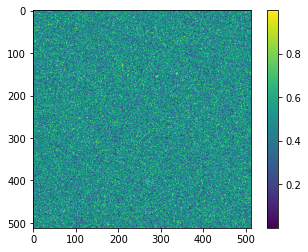

In [78]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(a_cpu)
plt.colorbar()

In [79]:
a_gpu = gpuarray.to_gpu(a_cpu)
b_gpu = gpuarray.to_gpu(b_cpu)
c_gpu = gpuarray.to_gpu(c_cpu)

In [80]:
%timeit c_cpu = a_cpu + b_cpu

10000 loops, best of 3: 163 µs per loop


In [83]:
from pycuda.compiler import SourceModule
cuda_kernel = """
__global__ void matrix_add(float *a, float *b, float *c) {
    int ix = blockDim.x * blockIdx.x + threadIdx.x;
    int iy = blockDim.y * blockIdx.y + threadIdx.y;
    int ib = gridDim.x * blockDim.x * ix + iy;
    c[ib] = a[ib] + b[ib];
}
"""
my_code = SourceModule(cuda_kernel)
matrix_add = my_code.get_function("matrix_add")
type(matrix_add)

pycuda._driver.Function

In [88]:
# Dividiamo la matrice 512x512 in 16x16 blocchi da 32x32
n_thr = (32, 32, 1)
n_blk = (16, 16, 1)
matrix_add(a_gpu, b_gpu, c_gpu, block=n_thr, grid=n_blk)

# Test
c_cpu = a_cpu + b_cpu
test = c_gpu.get() / c_cpu 
print(test)
print(np.count_nonzero(test != 1))

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
0


In [89]:
%timeit matrix_add(a_gpu, b_gpu, c_gpu, block=n_thr, grid=n_blk)

The slowest run took 6.69 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 34.9 µs per loop


In [90]:
# In realtà c'è un metodo migliore
matrix_add.prepare("PPP")
matrix_add.prepared_call(n_blk, n_thr,
                         a_gpu.gpudata, b_gpu.gpudata, c_gpu.gpudata)

In [93]:
# Questo fa comodo per misurare il tempo GPU in maniera diretta
delta_t = matrix_add.prepared_timed_call(n_blk, n_thr,
                                         a_gpu.gpudata, b_gpu.gpudata,
                                         c_gpu.gpudata)
print(f"Time = {delta_t()*1e6:.3f} us")

Time = 137.600 us


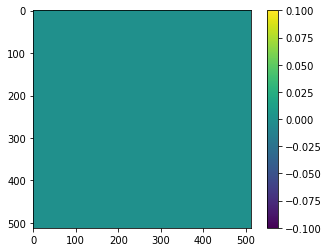

In [95]:
plt.imshow(c_gpu.get() - c_cpu, interpolation='none')
plt.colorbar()

## Prodotto di matrici
*Qui è finito il tempo della lezione.*

Il prof. Lamanna ci fa vedere che, eseguendo la moltiplicazione fra le matrici di prima in maniera analoga (si usa un kernel in cui ogni thread calcola un elemento diverso della matrice-risultato, così non ci sono race conditions) ci sono delle differenze tra il risultato della CPU e quello della GPU.

Questo non è un problema di GPU, ma un problema di processori diversi: nella moltiplicazione di numeri piccoli (che richiede molta precisione) processori diversi possono usare approssimazioni diverse.

Si può migliorare il risultato (ma non azzerare le differenza) utilizzando numeri in doppia precisione.

## Guadagno in tempo
*Sempre frettolosamente.*

Vediamo la differenza in tempo della somma di vettori random di dimensioni diverse.